In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm
from matplotlib.image import imread, imsave
from skimage.color import rgb2lab, lab2rgb
from apex import amp
from torch.utils.data import Dataset, DataLoader
from torchvision import models

In [2]:
torch.backends.cudnn.benchmark = True

## Data

In [3]:
def unpack_dataset():
    ! mkdir -p data
    
    # train dataset
    ! wget http://data.csail.mit.edu/places/places365/train_256_places365standard.tar
    ! tar -xvf train_256_places365standard.tar -C data
    
    # validation dataset
    # ! wget http://data.csail.mit.edu/places/places365/val_256.tar
    # ! tar -xvf val_256.tar -C data
    
    # test dataset
    # ! wget http://data.csail.mit.edu/places/places365/test_256.tar
    # ! tar -xvf test_256.tar -C data

In [4]:
# unpack_dataset()

In [5]:
PATH = Path("data/")
list(PATH.iterdir())

[PosixPath('data/val_256')]

## Dataset

In [6]:
class ImageDataset(Dataset):
    def __init__(self, files):
        self.files = np.array(files)
    
    def __getitem__(self, idx):
        img = imread(self.files[idx])
        if img.shape == (256, 256, 3):  # if a color image
            img_lab = rgb2lab(img)
            img_lab = (img_lab + [0, 128, 128]) / [100, 255, 255]  # normalize L, a, b dimensions
            img_lightness = img_lab[:, :, 0:1].transpose(2, 0, 1)
            img_ab = img_lab[:, :, 1:3].transpose(2, 0, 1)
        else:  # if a grayscale image
            img_lightness = (img/255)[None, :, :]
            img_ab = np.zeros(shape=(2, 256, 256))
        return img_lightness, img_ab
    
    def __len__(self):
        return len(self.files)

In [7]:
val_files = glob.glob("data/val_256/*.jpg")
len(val_files)

36500

In [8]:
train, val = val_files[:29200], val_files[29200:]

In [9]:
train_ds = ImageDataset(train)
val_ds = ImageDataset(val)

In [10]:
batch_size = 30
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=10)
val_dl = DataLoader(val_ds, batch_size=batch_size, pin_memory=True, num_workers=10)

## ResNet Model

In [11]:
def basic_block(in_, out_, kernel_size=3, stride=1):
    """Return a block consisting of a conv2d, ReLU and BatchNorm2d layer."""
    padding = kernel_size // 2
    block = nn.Sequential(
        nn.Conv2d(in_, out_, kernel_size, stride, padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_))
    return block

In [12]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        resnet = models.resnet34(pretrained=True)
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1, keepdim=True))
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.upsample1 = nn.Upsample(scale_factor=4)
        self.upsample2 = nn.Upsample(scale_factor=8)
        self.out_layer = basic_block(512, 2, kernel_size=3, stride=1)
    
    def forward(self, x):
        x = self.features1(x)
        x = self.upsample1(x)
        x = self.features2(x)
        x = self.upsample2(x)
        return self.out_layer(x)

## Training

In [13]:
def save_model(model, path): torch.save(model.state_dict(), path)

def load_model(model, path): model.load_state_dict(torch.load(path))

In [14]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

In [15]:
def create_optimizer(model, lr0):
    params = [{"params": model.features1.parameters(), "lr": lr0/9},
              {"params": model.features2.parameters(), "lr": lr0/3},
              {"params": model.upsample1.parameters(), "lr": lr0/9},
              {"params": model.upsample2.parameters(), "lr": lr0/3},
              {"params": model.out_layer.parameters(), "lr": lr0}]
    return optim.Adam(params, weight_decay=1e-5)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [16]:
def train_triangular_policy(model, optimizer, train_dl, val_dl, max_lr=0.01, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    pbar = tqdm(total=iterations)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    best_val_loss = float("inf")
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total = 0
        
        for x, y in train_dl:
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr/9, lr/3, lr])
            x = x.float().cuda()
            y = y.float().cuda()
            y_hat = model(x)
            loss = F.mse_loss(y_hat, y)
            optimizer.zero_grad()
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            optimizer.step()
            total_loss += loss.item() * y.shape[0]
            total += y.shape[0]
            idx += 1
            pbar.update()
        val_loss = val_metrics(model, val_dl)
        print(f"train loss: {total_loss/total:.8f}\tval loss: {val_loss:.8f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            path = f"models/model_{best_val_loss:.6f}.pth"
            save_model(model, path)
            print(path)
    return best_val_loss

In [17]:
def val_metrics(model, val_dl):
    model.eval()
    total_loss = 0
    total = 0
    y_pred = []
    y_true = []
    
    for x, y in val_dl:
        x = x.float().cuda()
        y = y.float()
        out = model(x)
        loss = F.mse_loss(out, y.cuda())
        total_loss += loss.item() * y.shape[0]
        total += y.shape[0]
        y_pred.append(out.cpu().detach().numpy())
        y_true.append(y)
    
    y_pred = np.vstack(y_pred)
    y_true = np.vstack(y_true)
    return total_loss/total

In [18]:
model = ColorizationNet().cuda()
optimizer = create_optimizer(model, 0.001)
model, optimizer = amp.initialize(model, optimizer, opt_level="O2", keep_batchnorm_fp32=True, loss_scale="dynamic")

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


In [19]:
best_val = train_triangular_policy(model, optimizer, train_dl, val_dl, epochs=1)

RuntimeError: CUDA out of memory. Tried to allocate 2.50 GiB (GPU 0; 11.93 GiB total capacity; 6.12 GiB already allocated; 996.50 MiB free; 10.51 GiB reserved in total by PyTorch) (malloc at /opt/conda/conda-bld/pytorch_1587428398394/work/c10/cuda/CUDACachingAllocator.cpp:289)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x4e (0x7ff4a6a7db5e in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x1f39d (0x7ff4a683f39d in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x2058e (0x7ff4a684058e in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #3: at::native::empty_cuda(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x291 (0x7ff4a97d6461 in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #4: <unknown function> + 0xddcb6b (0x7ff4a7a86b6b in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #5: <unknown function> + 0xe26457 (0x7ff4a7ad0457 in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #6: <unknown function> + 0xdd3999 (0x7ff4cea32999 in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #7: <unknown function> + 0xdd3cd7 (0x7ff4cea32cd7 in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #8: <unknown function> + 0xd77a7e (0x7ff4a7a21a7e in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #9: <unknown function> + 0xd7a543 (0x7ff4a7a24543 in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #10: at::native::cudnn_convolution_backward_input(c10::ArrayRef<long>, at::Tensor const&, at::Tensor const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, long, bool, bool) + 0xb2 (0x7ff4a7a24d82 in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #11: <unknown function> + 0xde18a0 (0x7ff4a7a8b8a0 in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #12: <unknown function> + 0xe26138 (0x7ff4a7ad0138 in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #13: at::native::cudnn_convolution_backward(at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, long, bool, bool, std::array<bool, 2ul>) + 0x4fa (0x7ff4a7a2641a in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #14: <unknown function> + 0xde1bcb (0x7ff4a7a8bbcb in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #15: <unknown function> + 0xe26194 (0x7ff4a7ad0194 in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #16: <unknown function> + 0x29defc6 (0x7ff4d063dfc6 in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #17: <unknown function> + 0x2a2ea54 (0x7ff4d068da54 in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #18: torch::autograd::generated::CudnnConvolutionBackward::apply(std::vector<at::Tensor, std::allocator<at::Tensor> >&&) + 0x378 (0x7ff4d0255f28 in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #19: <unknown function> + 0x2ae8215 (0x7ff4d0747215 in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #20: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&) + 0x16f3 (0x7ff4d0744513 in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #21: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&, bool) + 0x3d2 (0x7ff4d07452f2 in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #22: torch::autograd::Engine::thread_init(int) + 0x39 (0x7ff4d073d969 in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #23: torch::autograd::python::PythonEngine::thread_init(int) + 0x38 (0x7ff4d3a84558 in /data/hzt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #24: <unknown function> + 0xc819d (0x7ff51423619d in /data/hzt/anaconda3/lib/python3.7/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6)
frame #25: <unknown function> + 0x76db (0x7ff5174c56db in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #26: clone + 0x3f (0x7ff5171ee88f in /lib/x86_64-linux-gnu/libc.so.6)


## Prediction

In [20]:
def show_prediction(model, image):
    """Given an image, show the grayscale, ground truth and prediction images"""
    img_rgb = imread(image)
    img_lab = rgb2lab(img_rgb)
    img_lab = (img_lab + [0, 128, 128]) / [100, 255, 255]
    img_lightness = img_lab[:, :, 0:1].transpose(2, 0, 1)
    img_ab = img_lab[:, :, 1:3].transpose(2, 0, 1)
    
    # grayscale
    img_gray = 255 * img_lightness.squeeze(0)
    
    # prediction
    model.eval()
    x = torch.FloatTensor(img_lightness[None, :, :, :]).cuda()
    y_hat = model(x).cpu().detach().numpy().squeeze(0)
    img_pred = np.concatenate([img_lightness, y_hat], axis=0).transpose(1, 2, 0)
    img_pred = img_pred * [100, 255, 255] - [0, 128, 128]
    img_pred = (255 * lab2rgb(img_pred)).astype("uint8")
    
    # show images
    images = [img_gray, img_rgb, img_pred]
    plt.figure(figsize=(9, 3), dpi=100)
    for idx in range(3):
        plt.subplot(1, 3, idx + 1)
        if idx == 0:
            plt.imshow(images[idx], cmap="gray")
        else:
            plt.imshow(images[idx])
        plt.axis("off")
    plt.show()

In [16]:
model = ColorizationNet().cuda()
load_model(model, "models/model_0.003039.pth")

In [34]:
val

['data/val_256/Places365_val_00016015.jpg',
 'data/val_256/Places365_val_00030702.jpg',
 'data/val_256/Places365_val_00019373.jpg',
 'data/val_256/Places365_val_00005901.jpg',
 'data/val_256/Places365_val_00029595.jpg',
 'data/val_256/Places365_val_00017942.jpg',
 'data/val_256/Places365_val_00032848.jpg',
 'data/val_256/Places365_val_00009571.jpg',
 'data/val_256/Places365_val_00014904.jpg',
 'data/val_256/Places365_val_00021427.jpg',
 'data/val_256/Places365_val_00022206.jpg',
 'data/val_256/Places365_val_00035863.jpg',
 'data/val_256/Places365_val_00034662.jpg',
 'data/val_256/Places365_val_00014260.jpg',
 'data/val_256/Places365_val_00035366.jpg',
 'data/val_256/Places365_val_00034097.jpg',
 'data/val_256/Places365_val_00011139.jpg',
 'data/val_256/Places365_val_00025513.jpg',
 'data/val_256/Places365_val_00013906.jpg',
 'data/val_256/Places365_val_00000590.jpg',
 'data/val_256/Places365_val_00022132.jpg',
 'data/val_256/Places365_val_00028556.jpg',
 'data/val_256/Places365_val_000

In [45]:
image = "data/val_256/Places365_val_00034662.jpg"

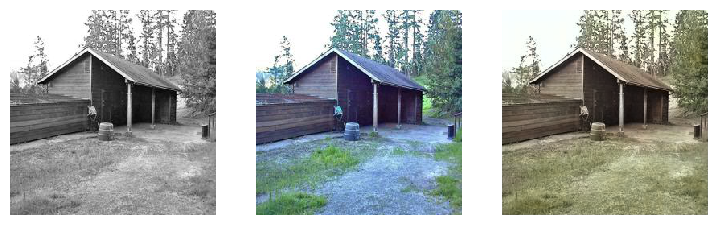

In [46]:
show_prediction(model, image)